In [20]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import RandomizedSearchCV

In [21]:
# Replace these file paths with the paths to your CSV files
file_paths = {
    "code_commits": "token_terminal_data/daily_code_commits.csv",
    "core_developers": "token_terminal_data/daily_core_developers.csv",
    "crv_price": "token_terminal_data/daily_crv_price.csv",
    "crv_token_holders": "token_terminal_data/daily_crv_token_holders.csv",
    "crv_trading_volume": "token_terminal_data/daily_crv_trading_volume.csv",
    "earnings": "token_terminal_data/daily_earnings.csv",
    "expenses": "token_terminal_data/daily_expenses.csv",
    "fees": "token_terminal_data/daily_fees.csv",
    "market_cap_circulating": "token_terminal_data/daily_market_cap_circulating.csv",
    "market_cap_fully_diluted": "token_terminal_data/daily_market_cap_fully_diluted.csv",
    "pf_ratio_circulating": "token_terminal_data/daily_pf_ratio_circulating.csv",
    "pf_ratio_fully_diluted": "token_terminal_data/daily_pf_ratio_fully_diluted.csv",
    "ps_ratio_circulating": "token_terminal_data/daily_ps_ratio_circulating.csv",
    "ps_ratio_fully_diluted": "token_terminal_data/daily_ps_ratio_fully_diluted.csv",
    "revenue": "token_terminal_data/daily_revenue.csv",
    "supplyside_fees": "token_terminal_data/daily_supplyside_fees.csv",
    "token_incentives": "token_terminal_data/daily_token_incentives.csv",
    "trading_volume_on_curve": "token_terminal_data/daily_trading_volume_on_curve.csv",
    "treasury": "token_terminal_data/daily_treasury.csv",
    "tvl": "token_terminal_data/daily_tvl.csv",
    "pool": "token_terminal_data/wbtc_weth_usdt_pool_data.csv"
}


# Initialize an empty DataFrame to merge all datasets
combined_df = None

# Read each file and merge it into the combined DataFrame
for file_label, file_path in file_paths.items():
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Assuming 'date' is the common column across all files
    if combined_df is None:
        combined_df = df
    else:
        combined_df = pd.merge(combined_df, df, on="date", how="outer")

In [22]:
# Assuming your DataFrame is named combined_df
combined_df['date'] = pd.to_datetime(combined_df['date'])
filtered_df = combined_df[combined_df['date'] >= '2021-01-01']

In [23]:
# Basic Statistics
print(filtered_df.describe())

                      date  code_commits  core_developers        price  \
count                 1055   1052.000000      1052.000000  1052.000000   
mean   2022-06-12 00:00:00      7.990494        11.833650     1.747215   
min    2021-01-01 00:00:00      0.000000         2.000000     0.400000   
25%    2021-09-21 12:00:00      3.000000         7.000000     0.810000   
50%    2022-06-12 00:00:00      7.000000        12.000000     1.230000   
75%    2023-03-02 12:00:00     11.000000        15.000000     2.462500   
max    2023-11-21 00:00:00     59.000000        27.000000     6.510000   
std                    NaN      6.935334         4.995896     1.228017   

       crv_token_holders  crv_trading_volume      earnings      expenses  \
count        1052.000000        1.052000e+03  1.052000e+03  1.052000e+03   
mean        63102.337452        1.903189e+08 -9.926103e+05  1.132878e+06   
min         15201.000000        1.445497e+07 -5.021059e+06  1.438209e+05   
25%         44653.250000     

In [24]:
filtered_df.columns

Index(['date', 'code_commits', 'core_developers', 'price', 'crv_token_holders',
       'crv_trading_volume', 'earnings', 'expenses', 'fees',
       'market_cap_circulating', 'market_cap_fully_diluted',
       'p_f_ratio_circulating', 'p_f_ratio_fully_diluted',
       'p_s_ratio_circulating', 'p_s_ratio_fully_diluted', 'revenue',
       'supply_side_fees', 'token_incentives', 'trading_volume', 'treasury',
       'tvl', 'pool_transaction_volume'],
      dtype='object')

In [25]:
filtered_df = filtered_df.drop('pool_transaction_volume', axis=1)

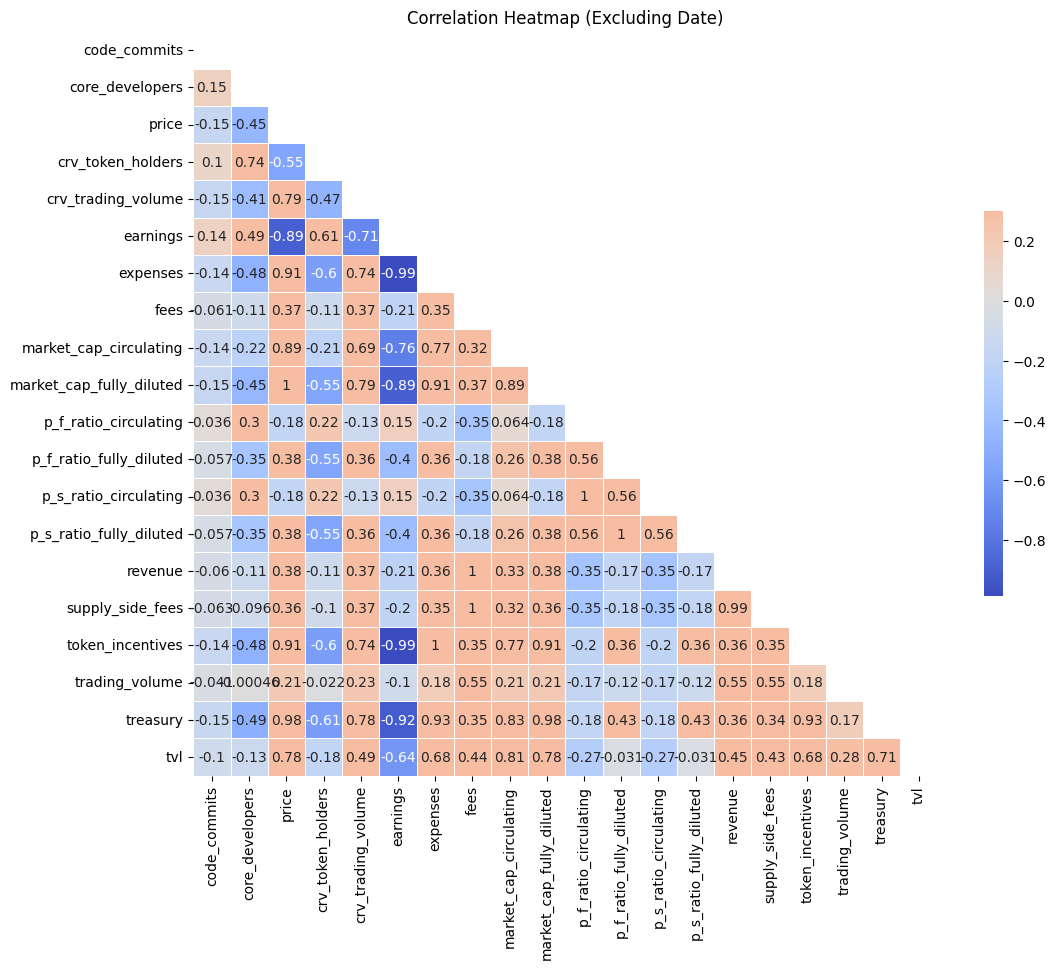

In [26]:
# Excluding the date column from the correlation matrix
numeric_df = filtered_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Heatmap (Excluding Date)')
plt.show()

### Step 1: Feature Engineering (Lagged Features)

In [27]:
filtered_df = combined_df[combined_df['date'] >= '2021-07-13']

In [28]:
df = filtered_df

In [29]:
features_to_lag_rolling = ['pool_transaction_volume']
rolling_window_sizes = [3, 5, 7, 10, 30, 60, 100, 120]

for feature in features_to_lag_rolling:
    for window in rolling_window_sizes:
        df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window).mean()
        df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window).std()

# Drop the rows with NaN values created by lag features and rolling windows
df = df.dropna()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [30]:
list(df.columns)

['date',
 'code_commits',
 'core_developers',
 'price',
 'crv_token_holders',
 'crv_trading_volume',
 'earnings',
 'expenses',
 'fees',
 'market_cap_circulating',
 'market_cap_fully_diluted',
 'p_f_ratio_circulating',
 'p_f_ratio_fully_diluted',
 'p_s_ratio_circulating',
 'p_s_ratio_fully_diluted',
 'revenue',
 'supply_side_fees',
 'token_incentives',
 'trading_volume',
 'treasury',
 'tvl',
 'pool_transaction_volume',
 'pool_transaction_volume_rolling_mean_3',
 'pool_transaction_volume_rolling_std_3',
 'pool_transaction_volume_rolling_mean_5',
 'pool_transaction_volume_rolling_std_5',
 'pool_transaction_volume_rolling_mean_7',
 'pool_transaction_volume_rolling_std_7',
 'pool_transaction_volume_rolling_mean_10',
 'pool_transaction_volume_rolling_std_10',
 'pool_transaction_volume_rolling_mean_30',
 'pool_transaction_volume_rolling_std_30',
 'pool_transaction_volume_rolling_mean_60',
 'pool_transaction_volume_rolling_std_60',
 'pool_transaction_volume_rolling_mean_100',
 'pool_transactio

In [31]:
list(df.columns)

['date',
 'code_commits',
 'core_developers',
 'price',
 'crv_token_holders',
 'crv_trading_volume',
 'earnings',
 'expenses',
 'fees',
 'market_cap_circulating',
 'market_cap_fully_diluted',
 'p_f_ratio_circulating',
 'p_f_ratio_fully_diluted',
 'p_s_ratio_circulating',
 'p_s_ratio_fully_diluted',
 'revenue',
 'supply_side_fees',
 'token_incentives',
 'trading_volume',
 'treasury',
 'tvl',
 'pool_transaction_volume',
 'pool_transaction_volume_rolling_mean_3',
 'pool_transaction_volume_rolling_std_3',
 'pool_transaction_volume_rolling_mean_5',
 'pool_transaction_volume_rolling_std_5',
 'pool_transaction_volume_rolling_mean_7',
 'pool_transaction_volume_rolling_std_7',
 'pool_transaction_volume_rolling_mean_10',
 'pool_transaction_volume_rolling_std_10',
 'pool_transaction_volume_rolling_mean_30',
 'pool_transaction_volume_rolling_std_30',
 'pool_transaction_volume_rolling_mean_60',
 'pool_transaction_volume_rolling_std_60',
 'pool_transaction_volume_rolling_mean_100',
 'pool_transactio

In [34]:
# Time series split
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

# Separate features and target without the 'date' column
features = [col for col in df.columns if col in ['pool_transaction_volume_lag_1', 'pool_transaction_volume_lag_2', 'pool_transaction_volume_lag_3', 'pool_transaction_volume_lag_4']]
X_train = train[features]
y_train = train['pool_transaction_volume']
X_test = test[features]
y_test = test['pool_transaction_volume']

In [35]:
# XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb_model.fit(X_train, y_train,
              early_stopping_rounds=5,
              eval_set=[(X_test, y_test)],
              verbose=False)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f'XGBoost RMSE: {xgb_rmse}')

XGBoostError: [04:27:47] /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:202: Check failed: n_features >= 1 (0 vs. 1) : Data must has at least 1 column.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000016c004998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000016c0f59ec xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 4196
  [bt] (2) 3   libxgboost.dylib                    0x000000016c0f4330 xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1072
  [bt] (3) 4   libxgboost.dylib                    0x000000016c0b23e4 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 140
  [bt] (4) 5   libxgboost.dylib                    0x000000016c00e4b0 XGQuantileDMatrixCreateFromCallback + 516
  [bt] (5) 6   libffi.dylib                        0x00000001a1be8050 ffi_call_SYSV + 80
  [bt] (6) 7   libffi.dylib                        0x00000001a1bf0af4 ffi_call_int + 1208
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010250e578 PyInit__ctypes + 24152
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000102507354 _ctypes.cpython-39-darwin.so + 29524



In [17]:
r2 = r2_score(y_test, xgb_pred)
r2

0.4203493940222469

[21:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


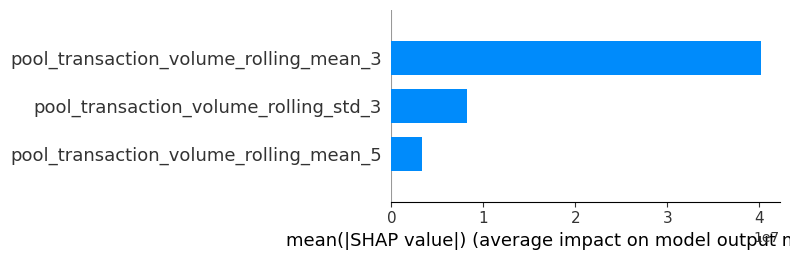

<Figure size 640x480 with 0 Axes>

In [261]:
# SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Increase the figure size
plt.figure(figsize=(1, 1))  # Adjust figure size as appropriate

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Tight layout often solves the issue of cutting off the edges
plt.tight_layout()

# Show the plot
plt.show()

Lets ignore the metrics that do not seem to have any impact on the pool trading volume